# Conversational agent

In [1]:
import os
import openai
from langchain.tools import tool

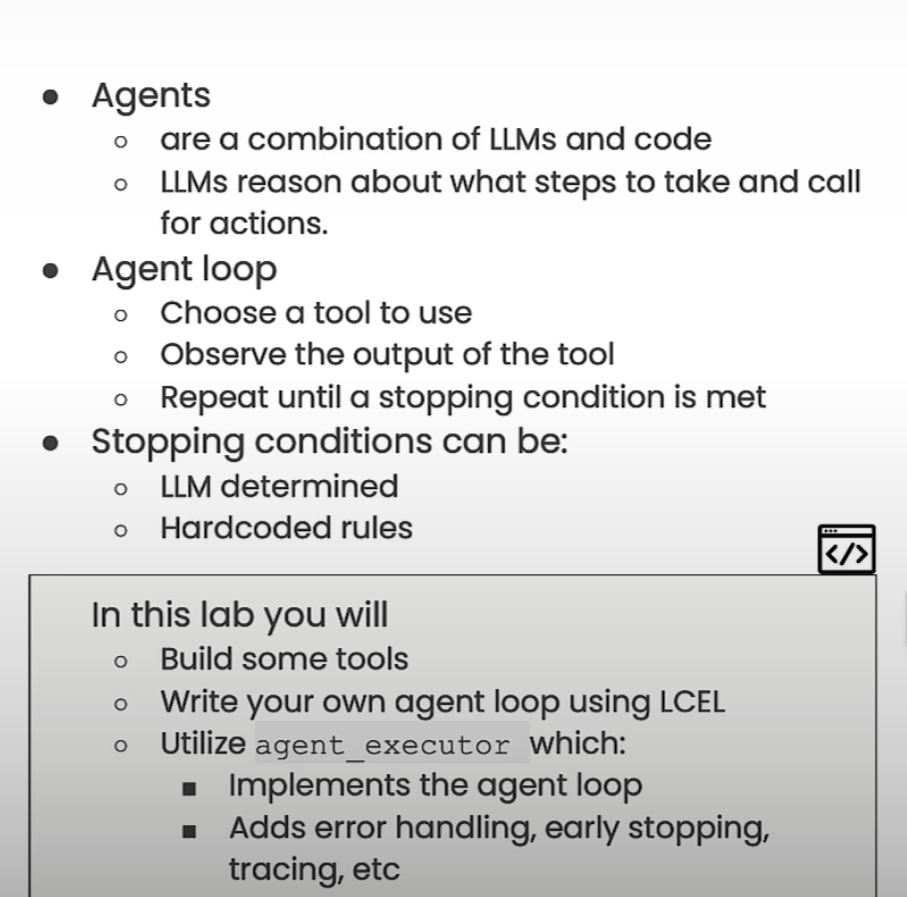

In [2]:
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""
    
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.now(datetime.UTC).replace(tzinfo=None)
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']
    
    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]
    
    return f'The current temperature is {current_temperature}°C'

In [3]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [4]:
tools = [get_current_temperature, search_wikipedia]

In [5]:
from langchain_openai.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [6]:
functions = [convert_to_openai_function(f) for f in tools]
model = ChatOpenAI(temperature=0).bind(functions=functions)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [7]:
result = chain.invoke({"input": "what is the weather is kgl?"})


In [8]:
result.tool

'get_current_temperature'

In [9]:
result.tool_input

{'latitude': -1.9706, 'longitude': 30.1044}

In [10]:
from langchain.prompts import MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [11]:
result1 = chain.invoke({
    "input":"what is the weather in Kigali",
    "agent_scratchpad":[]
})

In [12]:
result1.tool

'get_current_temperature'

In [13]:
observation = get_current_temperature(result1.tool_input)

C:\Users\Villard\AppData\Local\Temp\ipykernel_12648\2954714551.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  observation = get_current_temperature(result1.tool_input)


In [14]:
observation

'The current temperature is 26.2°C'

In [15]:
from langchain.agents.format_scratchpad import format_to_openai_functions

In [16]:
print(result1.message_log)

[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":-1.9706,"longitude":30.1044}', 'name': 'get_current_temperature'}, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 113, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-c3f1648d-3f92-4b41-9c3b-32f53cff8bbf-0', usage_metadata={'input_tokens': 113, 'output_tokens': 26, 'total_tokens': 139, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]


In [17]:
format_to_openai_functions([(result1, observation), ])

[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":-1.9706,"longitude":30.1044}', 'name': 'get_current_temperature'}, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 113, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-c3f1648d-3f92-4b41-9c3b-32f53cff8bbf-0', usage_metadata={'input_tokens': 113, 'output_tokens': 26, 'total_tokens': 139, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 FunctionMessage(content='The current temperature is 26.2°C', additional_kwargs={}, response_metadata={}, name='get_current_temperature')]

In [18]:
result2 = chain.invoke({
    "input":"what is the weather in Kigali",
    "agent_scratchpad": format_to_openai_functions([(result1, observation)])

})
result2

AgentFinish(return_values={'output': 'The current temperature in Kigali is 26.2°C.'}, log='The current temperature in Kigali is 26.2°C.')

In [19]:
from langchain.schema.agent import AgentFinish

In [20]:
from langchain.schema.runnable import RunnablePassthrough

agent_chain = RunnablePassthrough.assign(
    agent_scratchpad = lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain

In [21]:
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = agent_chain.invoke({
            "input": user_input,
            "intermediate_steps": intermediate_steps
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia,
            "get_current_temperature":get_current_temperature
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [22]:
run_agent("what is the weather in Kigali")

AgentFinish(return_values={'output': 'The current temperature in Kigali is 26.2°C.'}, log='The current temperature in Kigali is 26.2°C.')

In [23]:
run_agent("hi")

AgentFinish(return_values={'output': 'Well, hello there! How can I assist you today?'}, log='Well, hello there! How can I assist you today?')

In [24]:
# All the steps listed above can be accomprished by applying this langchain method
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True)

In [25]:
agent_executor.invoke({"input":"what is the weather in Kigali"})



> Entering new AgentExecutor chain...

Invoking: `get_current_temperature` with `{'latitude': -1.9706, 'longitude': 30.1044}`


The current temperature is 26.2°CThe current temperature in Kigali is 26.2°C.

> Finished chain.


{'input': 'what is the weather in Kigali',
 'output': 'The current temperature in Kigali is 26.2°C.'}

In [26]:
agent_executor.invoke({"input":"what is langchain"})



> Entering new AgentExecutor chain...

Invoking: `search_wikipedia` with `{'query': 'Langchain'}`


Page: LangChain
Summary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

Page: Milvus (vector database)
Summary: Milvus is a distributed vector database developed by Zilliz. It is available as both open-source software and a cloud service.
Milvus is an open-source project under LF AI & Data Foundation distributed under the Apache License 2.0.



Page: Retrieval-augmented generation
Summary: Retrieval Augmented Generation (RAG) is a technique that grants generative artificial intelligence models information retrieval capabilities. It modifies interactions with a large language model (LLM) so that the model responds t

{'input': 'what is langchain',
 'output': 'I couldn\'t find specific information about "Langchain." It seems like it might not be a widely recognized term or topic. If you have any other questions or need assistance with something else, feel free to ask!'}

In [27]:
agent_executor.invoke({"input":"my name is Herve"})



> Entering new AgentExecutor chain...
Nice to meet you, Herve! How can I assist you today?

> Finished chain.


{'input': 'my name is Herve',
 'output': 'Nice to meet you, Herve! How can I assist you today?'}

In [28]:
agent_executor.invoke({"input":"what is my name"})



> Entering new AgentExecutor chain...
I'm sorry, I don't have access to your personal information. How can I assist you today?

> Finished chain.


{'input': 'what is my name',
 'output': "I'm sorry, I don't have access to your personal information. How can I assist you today?"}

In [29]:
# In order for the model to remember my name, 
# I have to pass another message placeholder to the prompt templace
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad = lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain

In [30]:
# Let create a memory object
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(return_messages=True, memory_key="chat_history")
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True, memory=memory)

C:\Users\Villard\AppData\Local\Temp\ipykernel_12648\2682563718.py:3: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(return_messages=True, memory_key="chat_history")


In [31]:
agent_executor.invoke({"input":"my name is Herve"})



> Entering new AgentExecutor chain...
Nice to meet you, Herve! How can I assist you today?

> Finished chain.


{'input': 'my name is Herve',
 'chat_history': [HumanMessage(content='my name is Herve', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Nice to meet you, Herve! How can I assist you today?', additional_kwargs={}, response_metadata={})],
 'output': 'Nice to meet you, Herve! How can I assist you today?'}

In [32]:
agent_executor.invoke({"input":"what's my name?"})



> Entering new AgentExecutor chain...
I'm sorry, I don't have access to your personal information. How can I assist you today?

> Finished chain.


{'input': "what's my name?",
 'chat_history': [HumanMessage(content='my name is Herve', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Nice to meet you, Herve! How can I assist you today?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry, I don't have access to your personal information. How can I assist you today?", additional_kwargs={}, response_metadata={})],
 'output': "I'm sorry, I don't have access to your personal information. How can I assist you today?"}